Firstly the onboarding of the CNCB and COVID-CT-MD datasets as they contain 3 classes (including normal pneumonia) and we need it to build a classifier that filters out common pneumonia cases

In [2]:
import sys ,os
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

import importlib
import utils as Utils
import numpy as np
import configparser
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import data_processing.data_processing_functions as DP
import dl_utils as DL
import cv2

importlib.reload(Utils)
importlib.reload(DP)
importlib.reload(DL)

config = configparser.ConfigParser()
config.read("../config.ini")
# pandas increase column size
pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
PROCESSED_DATA_PATH = config["PATHS"]["PROCESSED_DATA_PATH"]
CLASSIFICATION_DATA_PATH = os.path.join(PROCESSED_DATA_PATH, "classification")
CLASSIFICATION_IMAGES_PATH = os.path.join(CLASSIFICATION_DATA_PATH, "images")
OBJECT_DETECTION_METADATA_PATH = os.path.join(PROCESSED_DATA_PATH, "object_detection", "metadata_with_bboxes.pkl")
CLASSIFICATION_METADATA_PATH = os.path.join(PROCESSED_DATA_PATH, "classification", "classification_metadata.pkl")


os.makedirs(CLASSIFICATION_DATA_PATH, exist_ok=True)
os.makedirs(CLASSIFICATION_IMAGES_PATH, exist_ok=True)

print(PROCESSED_DATA_PATH)
print(CLASSIFICATION_METADATA_PATH)

/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/classification_metadata.pkl


# Generate Classification Dataset

## COVID-CT-MD

In [4]:
# COVID_CT_MD_PATH = config["PATHS"]["COVID_CT_MD_PATH"]
COVID_CT_MD_PATH = "/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/RELOADED_COVID_CT_MD/"
index_df = pd.read_csv(os.path.join(COVID_CT_MD_PATH, "Index.csv"))
slice_level_labels = np.load(os.path.join(COVID_CT_MD_PATH, "Slice-level-labels.npy"), allow_pickle=True)

root_dir = COVID_CT_MD_PATH
folders = ['Normal Cases', 'Cap Cases', 'COVID-19 Cases']
data = []
for folder in folders:
    folder_path = os.path.join(root_dir, folder)
    
    # Iterate through each patient folder
    for patient_folder in tqdm(os.listdir(folder_path)):
        if patient_folder.startswith('.'):
            continue
        #remove all non numerical characters
        patient_id = ''.join(filter(str.isdigit, patient_folder))
        
        # Iterate through each .dcm file
        dcm_slices_list = os.listdir(os.path.join(folder_path, patient_folder))
        n_slices = len(dcm_slices_list)
        for file_name in dcm_slices_list:
            if file_name.endswith('.dcm'):
                slice_number = file_name.split('.dcm')[0].split('IM0')[1]
                file_path = os.path.join(folder_path, patient_folder, file_name)
                # Determine the label based on the folder name
                if folder == 'Normal Cases':
                    label = 'normal'
                elif folder == 'Cap Cases':
                    label = 'common-pneumonia'
                else:
                    label = 'covid'
                
                # Append the data to the list
                data.append(
                    {
                        'patient_id': int(patient_id),
                        'scan_index': int(patient_id),
                        'label': label,
                        'slice_index': int(slice_number),
                        "n_slices": int(n_slices),
                        'ct_slice_path': file_path
                    }
                )

ct_slices_df = pd.DataFrame(data)
index_df["patient_id"] = index_df["Folder/ID"].apply(lambda x: ''.join(filter(str.isdigit, x))).astype(int)
index_df["label"] = index_df["Diagnosis"].apply(lambda x: "common-pneumonia" if x == "CAP" else "covid")
index_df["label_index"] = index_df["Label Index"].astype(int)
index_df["label_index"] = index_df["label_index"].apply(lambda x: x - 1 if x > 42 else x) # There is an error in the index file
enriched_index_df = index_df[["patient_id", "label_index", "label"]]
ct_slices_with_labels_df = ct_slices_df.merge(enriched_index_df, on=["patient_id", "label"], how="left")
print(ct_slices_df.shape)
print(ct_slices_with_labels_df.shape)
ct_slices_with_labels_df.head()

  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 170/170 [00:00<00:00, 2254.40it/s]

(45471, 6)
(45471, 7)


,patient_id,scan_index,label,slice_index,n_slices,ct_slice_path,label_index
0,55,55,normal,107,144,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/RELOADED_COVID_CT_MD/Normal Cases/normal055/IM0107.dcm,NaN
1,55,55,normal,95,144,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/RELOADED_COVID_CT_MD/Normal Cases/normal055/IM0095.dcm,NaN
2,55,55,normal,5,144,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/RELOADED_COVID_CT_MD/Normal Cases/normal055/IM0005.dcm,NaN
3,55,55,normal,128,144,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/RELOADED_COVID_CT_MD/Normal Cases/normal055/IM0128.dcm,NaN
4,55,55,normal,17,144,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/RELOADED_COVID_CT_MD/Normal Cases/normal055/IM0017.dcm,NaN


### We need to read the dcm and convert them into .png first

In [28]:
processed_covid_ct_md_path = os.path.join(CLASSIFICATION_IMAGES_PATH, "covid_ct_md")
normal_ct_md_subfolder = os.path.join(processed_covid_ct_md_path, "normal")
covid_ct_md_subfolder = os.path.join(processed_covid_ct_md_path, "covid")
cap_ct_md_subfolder = os.path.join(processed_covid_ct_md_path, "common-pneumonia")
print(processed_covid_ct_md_path)
print(normal_ct_md_subfolder)
print(covid_ct_md_subfolder)
print(cap_ct_md_subfolder)

os.makedirs(processed_covid_ct_md_path, exist_ok=True)
os.makedirs(normal_ct_md_subfolder, exist_ok=True)
os.makedirs(covid_ct_md_subfolder, exist_ok=True)
os.makedirs(cap_ct_md_subfolder, exist_ok=True)

/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/images/covid_ct_md
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/images/covid_ct_md/normal
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/images/covid_ct_md/covid
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/images/covid_ct_md/common-pneumonia


In [32]:
data = []
# Uncomment for first run

# for label in ["normal", "covid", "common-pneumonia"]:
#     images_folder = os.listdir(os.path.join(covid_ct_md_path, label))
#     for image in tqdm(images_folder):
#         image_path = os.path.join(covid_ct_md_path, label, image)
#         image_name = image.split(".")[0]
#         scan_index = image_name.split("_")[3]
#         slice_index = image_name.split("_")[4]
#         data.append([label, scan_index, slice_index, image_path])

# covid_ct_md_df = pd.DataFrame(data, columns=["label", "scan_index", "slice_index", "ct_slice_path"])
# print(covid_ct_md_df.shape)


written_dcm_set = set([*os.listdir(normal_ct_md_subfolder), *os.listdir(covid_ct_md_subfolder), *os.listdir(cap_ct_md_subfolder)])
error_data = []
data = []
for i, row in tqdm(ct_slices_with_labels_df.iterrows(), total=ct_slices_with_labels_df.shape[0]):
    dicom_path = row["ct_slice_path"]
    label = row["label"]
    scan_index = row["scan_index"]
    slice_index = row["slice_index"]
    file_nm = dicom_path.split("/")[-1].split(".")[0]
    new_file_name = f"covid_ct_md_{scan_index}_{slice_index}_{file_nm}.png"
    new_file_path = os.path.join(processed_covid_ct_md_path, label, new_file_name)
    row["ct_slice_path"] = new_file_path
    # Only append if dcm has not already been written
    if new_file_name not in written_dcm_set:
        ct = Utils.read_dicom(dicom_path, modality_lut=True, voi_lut=True, view_index=1, fix_monochrome=True, rescale=True)
        assert cv2.imwrite(new_file_path, ct, [cv2.IMWRITE_PNG_COMPRESSION, 1])
        data.append(row)
    else:
        data.append(row)
uncorrupted_data_df = pd.DataFrame(data)
uncorrupted_data_df["ct_slice_path"] = uncorrupted_data_df["ct_slice_path"].apply(lambda x: x.replace(".dcm", ".png"))
uncorrupted_data_df["dataset"] = "COVID_CT_MD"
print(uncorrupted_data_df.shape)


  0%|          | 0/45471 [00:00<?, ?it/s]

100%|██████████| 45471/45471 [1:09:26<00:00, 10.91it/s]


(45471, 8)


### Including the slice-level metadata

In [33]:
uncorrupted_data_df["has_infection"] = (
    uncorrupted_data_df
    .apply(
    lambda row:
      False
        if pd.isna(row["label_index"])
        else (
            True if slice_level_labels[int(row["label_index"])][int(row["slice_index"])-1] > 0
            else False),
        axis=1
        )
)
uncorrupted_data_df["patient_index"] = uncorrupted_data_df["patient_id"]
uncorrupted_data_df.drop(columns=["label_index", "patient_id"], inplace=True)
print(uncorrupted_data_df.shape)
print(uncorrupted_data_df.dtypes)
uncorrupted_data_df.head()

(45471, 8)
scan_index        int64
label            object
slice_index       int64
n_slices          int64
ct_slice_path    object
dataset          object
has_infection      bool
patient_index     int64
dtype: object


,scan_index,label,slice_index,n_slices,ct_slice_path,dataset,has_infection,patient_index
0,55,normal,107,144,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/images/covid_ct_md/normal/covid_ct_md_55_107_IM0107.png,COVID_CT_MD,False,55
1,55,normal,95,144,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/images/covid_ct_md/normal/covid_ct_md_55_95_IM0095.png,COVID_CT_MD,False,55
2,55,normal,5,144,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/images/covid_ct_md/normal/covid_ct_md_55_5_IM0005.png,COVID_CT_MD,False,55
3,55,normal,128,144,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/images/covid_ct_md/normal/covid_ct_md_55_128_IM0128.png,COVID_CT_MD,False,55
4,55,normal,17,144,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/images/covid_ct_md/normal/covid_ct_md_55_17_IM0017.png,COVID_CT_MD,False,55


## Cleaned CNCB

In [34]:
CLEANED_CNCB_PATH = config['PATHS']['CLEANED_CNCB_PATH']
LESION_SLICES_PATH = os.path.join(CLEANED_CNCB_PATH, 'lesions_slices.csv')

In [35]:
cncb_df = DP.read_cleaned_cncb_folder_structure(CLEANED_CNCB_PATH)
print(cncb_df.shape)
cncb_df.head()

(397943, 8)


,label,patient_index,scan_index,slice_index,n_slices,ct_slice_path,lung_mask_path,dataset
0,normal,2118,573,79,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0079.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0079.png,CNCB
1,normal,2118,573,16,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0016.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0016.png,CNCB
2,normal,2118,573,25,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0025.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0025.png,CNCB
3,normal,2118,573,42,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0042.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0042.png,CNCB
4,normal,2118,573,76,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0076.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0076.png,CNCB


In [36]:
lesion_slices_df = pd.read_csv(LESION_SLICES_PATH)
lesion_slices_df["label"] = lesion_slices_df["imgpath"].apply(lambda x: x.split("/")[0]).apply(lambda x: "covid" if x == "NCP" else "common-pneumonia")
lesion_slices_df["patient_index"] = lesion_slices_df["imgpath"].apply(lambda x: x.split("/")[1]).astype(int)
lesion_slices_df["scan_index"] = lesion_slices_df["imgpath"].apply(lambda x: x.split("/")[2]).astype(int)
lesion_slices_df["slice_index"] = lesion_slices_df["imgpath"].apply(lambda x: x.split("/")[3].split(".")[0]).astype(int)
lesion_slices_df["has_infection"] = True
print(lesion_slices_df.shape)

(58766, 6)


In [37]:
final_cncb_df = (
    cncb_df
    .merge(lesion_slices_df, on=["label", "patient_index", "scan_index", "slice_index"], how="left")
)
final_cncb_df = final_cncb_df[
    ["label", "patient_index", "scan_index", "slice_index", "n_slices", "ct_slice_path","lung_mask_path", "dataset", "has_infection", "imgpath"]]

final_cncb_df["has_infection"] = final_cncb_df["has_infection"].fillna(False)

print(final_cncb_df.shape)
print(final_cncb_df.dtypes)
print(final_cncb_df.groupby("has_infection").size())
final_cncb_df.head()

(397943, 10)
label             object
patient_index      int64
scan_index         int64
slice_index        int64
n_slices           int64
ct_slice_path     object
lung_mask_path    object
dataset           object
has_infection       bool
imgpath           object
dtype: object
has_infection
False    339688
True      58255
dtype: int64


,label,patient_index,scan_index,slice_index,n_slices,ct_slice_path,lung_mask_path,dataset,has_infection,imgpath
0,normal,2118,573,79,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0079.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0079.png,CNCB,False,NaN
1,normal,2118,573,16,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0016.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0016.png,CNCB,False,NaN
2,normal,2118,573,25,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0025.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0025.png,CNCB,False,NaN
3,normal,2118,573,42,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0042.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0042.png,CNCB,False,NaN
4,normal,2118,573,76,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0076.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0076.png,CNCB,False,NaN


## Combine both datasets assign splits and sanity checks

In [38]:
# Concat both dataframes
print(uncorrupted_data_df.dtypes)
print(final_cncb_df.dtypes)
metadata_df = pd.concat([final_cncb_df, uncorrupted_data_df ], axis=0)
metadata_df.reset_index(inplace=True, drop=True)
metadata_df["height"] = 512
metadata_df["width"] = 512

metadata_df = DL.stratified_group_train_test_split_df(
    metadata_df,
    random_state=None,
    stratify_columns=["dataset", "label"],
    group_columns=["dataset", "patient_index", "scan_index"]
    )
metadata_df = DL.stratified_group_kfold_split_dataframe(
    metadata_df,
    n_splits=5,
    random_state=None,
    stratify_columns=["dataset", "label"],
    group_columns=["dataset", "patient_index", "scan_index"]
)

print(metadata_df.shape)
print(metadata_df.groupby(["dataset", "label"]).size())
print(metadata_df.groupby(["split", "dataset", "label"]).size())
print(f"Total train size: {metadata_df[metadata_df['split'] == 'train'].shape[0]}")
print(f"Total test size: {metadata_df[metadata_df['split'] == 'test'].shape[0]}")
metadata_df.head()

scan_index        int64
label            object
slice_index       int64
n_slices          int64
ct_slice_path    object
dataset          object
has_infection      bool
patient_index     int64
dtype: object
label             object
patient_index      int64
scan_index         int64
slice_index        int64
n_slices           int64
ct_slice_path     object
lung_mask_path    object
dataset           object
has_infection       bool
imgpath           object
dtype: object
(443414, 18)
dataset      label           
CNCB         common-pneumonia    157939
             covid               152790
             normal               87214
COVID_CT_MD  common-pneumonia      9127
             covid                24939
             normal               11405
dtype: int64
split  dataset      label           
test   CNCB         common-pneumonia     31591
                    covid                30560
                    normal               17459
       COVID_CT_MD  common-pneumonia      1910
         

,label,patient_index,scan_index,slice_index,n_slices,ct_slice_path,lung_mask_path,dataset,has_infection,imgpath,height,width,split,split_0,split_1,split_2,split_3,split_4
0,normal,2118,573,79,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0079.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0079.png,CNCB,False,NaN,512,512,train,train,test,train,train,train
1,normal,2118,573,16,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0016.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0016.png,CNCB,False,NaN,512,512,train,train,test,train,train,train
2,normal,2118,573,25,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0025.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0025.png,CNCB,False,NaN,512,512,train,train,test,train,train,train
3,normal,2118,573,42,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0042.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0042.png,CNCB,False,NaN,512,512,train,train,test,train,train,train
4,normal,2118,573,76,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0076.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0076.png,CNCB,False,NaN,512,512,train,train,test,train,train,train


In [39]:
# Sample a rows from each dataset for each label both with has_infection = True and has_infection = False
sampled_metadata_df = (
    metadata_df
    .groupby(["dataset", "label", "has_infection", "split"])
    .apply(lambda x: x.sample(1))
    .reset_index(drop=True)
)
print(sampled_metadata_df.shape)
sampled_metadata_df.head(3*2*2*2)

(20, 18)


,label,patient_index,scan_index,slice_index,n_slices,ct_slice_path,lung_mask_path,dataset,has_infection,imgpath,height,width,split,split_0,split_1,split_2,split_3,split_4
0,common-pneumonia,1339,3718,40,59,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/CP/1339/3718/0040.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/CP/1339/3718/0040.png,CNCB,False,NaN,512,512,test,train,train,train,train,test
1,common-pneumonia,1114,3332,54,361,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/CP/1114/3332/0054.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/CP/1114/3332/0054.png,CNCB,False,NaN,512,512,train,test,train,train,train,train
2,common-pneumonia,1790,3209,44,69,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/CP/1790/3209/0044.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/CP/1790/3209/0044.png,CNCB,True,CP/1790/3209/0044.png,512,512,test,train,train,train,train,test
3,common-pneumonia,3722,5657,174,205,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/CP/3722/5657/0174.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/CP/3722/5657/0174.png,CNCB,True,CP/3722/5657/0174.png,512,512,train,train,test,train,train,train
4,covid,501,2158,90,146,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/NCP/501/2158/0090.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/NCP/501/2158/0090.png,CNCB,False,NaN,512,512,test,train,train,train,train,test
5,covid,54,1241,124,147,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/NCP/54/1241/0124.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/NCP/54/1241/0124.png,CNCB,False,NaN,512,512,train,train,test,train,train,train
6,covid,203,1550,87,140,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/NCP/203/1550/0087.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/NCP/203/1550/0087.png,CNCB,True,NCP/203/1550/0087.png,512,512,test,train,train,train,train,test
7,covid,382,1917,47,58,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/NCP/382/1917/0047.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/NCP/382/1917/0047.png,CNCB,True,NCP/382/1917/0047.png,512,512,train,train,train,train,test,train
8,normal,1678,828,5,58,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/1678/828/0005.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/1678/828/0005.png,CNCB,False,NaN,512,512,test,train,train,train,train,test
9,normal,3837,5349,35,208,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/3837/5349/0035.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/3837/5349/0035.png,CNCB,False,NaN,512,512,train,train,train,test,train,train


Index(['label', 'patient_index', 'scan_index', 'slice_index', 'n_slices',
       'ct_slice_path', 'lung_mask_path', 'dataset', 'has_infection',
       'imgpath', 'height', 'width', 'split', 'split_0', 'split_1', 'split_2',
       'split_3', 'split_4'],
      dtype='object')


<Axes: xlabel='split,dataset'>

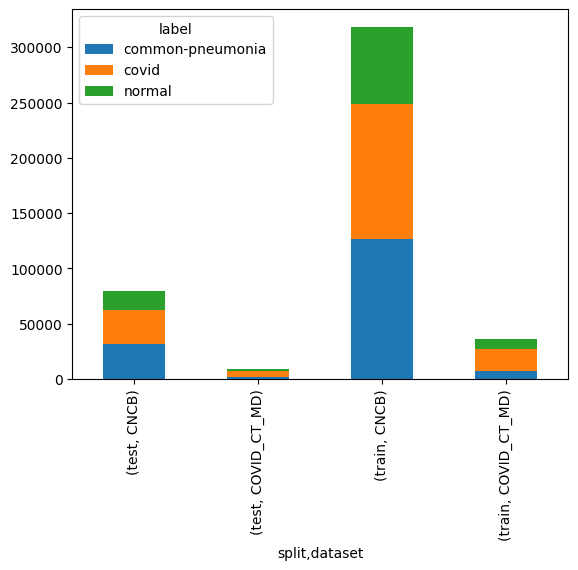

In [22]:
print(metadata_df.columns)
# visualize the split
metadata_df.groupby(["split", "dataset", "label"]).size().unstack(fill_value=0).plot(kind='bar', stacked=True)


In [43]:
for dataset in metadata_df["dataset"].unique():
    dataset_df = metadata_df[metadata_df["dataset"] == dataset]
    # Check that no scan_index is repeated in both splits
    train_scan_indexes = dataset_df[dataset_df["split"] == "train"]["scan_index"].unique()
    test_scan_indexes = dataset_df[dataset_df["split"] == "test"]["scan_index"].unique()
    assert len(set(train_scan_indexes).intersection(set(test_scan_indexes))) == 0

sample_df = metadata_df.sample(1000)
for i, row in sample_df.iterrows():
    print(row["ct_slice_path"])
    img = cv2.imread(row["ct_slice_path"], cv2.IMREAD_UNCHANGED)
    if (img.shape != (512, 512)):
        print(f"Error in {row['ct_slice_path']} shape is {img.shape}")

/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/NCP/823/2334/0093.png
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/NCP/267/1680/0064.png
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/NCP/480/2116/0009.png
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/CP/2668/3256/0042.png
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/CP/708/3070/0020.png
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/NCP/582/2322/0037.png
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/NCP/76/1285/0003.png
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/CP/1510/4122/0030.png
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/CP/3733/5675/0037.png
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/NCP/328/1804/0

KeyboardInterrupt: 

In [42]:
# Save the classifciation metadata
metadata_df.to_pickle(CLASSIFICATION_METADATA_PATH)

# Combine metadata with object detection dataset

In [5]:
print(CLASSIFICATION_METADATA_PATH)
print(OBJECT_DETECTION_METADATA_PATH)
classification_metadata_df = pd.read_pickle(CLASSIFICATION_METADATA_PATH)
object_detection_metadata_df = pd.read_pickle(OBJECT_DETECTION_METADATA_PATH)
print("Classification metadata shape", classification_metadata_df.shape)
print("Object detection metadata shape", object_detection_metadata_df.shape)
classification_metadata_df.head()

/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/classification_metadata.pkl
/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/object_detection/metadata_with_bboxes.pkl
Classification metadata shape (443414, 18)
Object detection metadata shape (87799, 81)


,label,patient_index,scan_index,slice_index,n_slices,ct_slice_path,lung_mask_path,dataset,has_infection,imgpath,height,width,split,split_0,split_1,split_2,split_3,split_4
0,normal,2118,573,79,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0079.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0079.png,CNCB,False,NaN,512,512,train,train,test,train,train,train
1,normal,2118,573,16,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0016.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0016.png,CNCB,False,NaN,512,512,train,train,test,train,train,train
2,normal,2118,573,25,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0025.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0025.png,CNCB,False,NaN,512,512,train,train,test,train,train,train
3,normal,2118,573,42,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0042.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0042.png,CNCB,False,NaN,512,512,train,train,test,train,train,train
4,normal,2118,573,76,89,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_cleaned/Normal/2118/573/0076.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CLEANED_CNCB/dataset_seg/Normal/2118/573/0076.png,CNCB,False,NaN,512,512,train,train,test,train,train,train


In [8]:
object_detection_metadata_df.head()

,dataset,label,scan_index,slice_index,ct_slice_path,infection_mask_path,lung_mask_path,height,width,has_infection,has_lung_mask,original_bbox,num_original_bboxes,nms_bboxes_25,nms_bboxes_50,nms_bboxes_50_merged,merged_hdbscan_bboxes_e0_7,merged_hdbscan_bboxes_e0_5,merged_hdbscan_bboxes_e0_3,merged_hdbscan_bboxes_e0_2,merged_hdbscan_bboxes_e0_1,merged_hdbscan_bboxes_e0_05,merged_hdbscan_bboxes_e0_01,merged_hdbscan_bboxes_e0_001,merged_hdbscan_bboxes_e0_0001,merged_hdbscan_bboxes_e0_7_with_sizes,merged_hdbscan_bboxes_e0_5_with_sizes,merged_hdbscan_bboxes_e0_3_with_sizes,merged_hdbscan_bboxes_e0_2_with_sizes,merged_hdbscan_bboxes_e0_1_with_sizes,merged_hdbscan_bboxes_e0_05_with_sizes,merged_hdbscan_bboxes_e0_01_with_sizes,merged_hdbscan_bboxes_e0_001_with_sizes,merged_hdbscan_bboxes_e0_0001_with_sizes,merged_hdbscan_bboxes_e0_7_threshold_10,merged_hdbscan_bboxes_e0_5_threshold_10,merged_hdbscan_bboxes_e0_3_threshold_10,merged_hdbscan_bboxes_e0_2_threshold_10,merged_hdbscan_bboxes_e0_1_threshold_10,merged_hdbscan_bboxes_e0_05_threshold_10,merged_hdbscan_bboxes_e0_01_threshold_10,merged_hdbscan_bboxes_e0_001_threshold_10,merged_hdbscan_bboxes_e0_0001_threshold_10,n_bboxes,split,split_0,split_1,split_2,split_3,split_4,%uncovered_mask_original_bbox,%uncovered_mask_nms_bboxes_25,%uncovered_mask_nms_bboxes_50,%uncovered_mask_nms_bboxes_50_merged,%uncovered_mask_merged_hdbscan_bboxes_e0_7,%uncovered_mask_merged_hdbscan_bboxes_e0_5,%uncovered_mask_merged_hdbscan_bboxes_e0_3,%uncovered_mask_merged_hdbscan_bboxes_e0_2,%uncovered_mask_merged_hdbscan_bboxes_e0_1,%uncovered_mask_merged_hdbscan_bboxes_e0_05,%uncovered_mask_merged_hdbscan_bboxes_e0_01,%uncovered_mask_merged_hdbscan_bboxes_e0_001,%uncovered_mask_merged_hdbscan_bboxes_e0_0001,%uncovered_mask_merged_hdbscan_bboxes_e0_7_with_sizes,%uncovered_mask_merged_hdbscan_bboxes_e0_5_with_sizes,%uncovered_mask_merged_hdbscan_bboxes_e0_3_with_sizes,%uncovered_mask_merged_hdbscan_bboxes_e0_2_with_sizes,%uncovered_mask_merged_hdbscan_bboxes_e0_1_with_sizes,%uncovered_mask_merged_hdbscan_bboxes_e0_05_with_sizes,%uncovered_mask_merged_hdbscan_bboxes_e0_01_with_sizes,%uncovered_mask_merged_hdbscan_bboxes_e0_001_with_sizes,%uncovered_mask_merged_hdbscan_bboxes_e0_0001_with_sizes,%uncovered_mask_merged_hdbscan_bboxes_e0_7_threshold_10,%uncovered_mask_merged_hdbscan_bboxes_e0_5_threshold_10,%uncovered_mask_merged_hdbscan_bboxes_e0_3_threshold_10,%uncovered_mask_merged_hdbscan_bboxes_e0_2_threshold_10,%uncovered_mask_merged_hdbscan_bboxes_e0_1_threshold_10,%uncovered_mask_merged_hdbscan_bboxes_e0_05_threshold_10,%uncovered_mask_merged_hdbscan_bboxes_e0_01_threshold_10,%uncovered_mask_merged_hdbscan_bboxes_e0_001_threshold_10,%uncovered_mask_merged_hdbscan_bboxes_e0_0001_threshold_10
68786,CNCB,covid,16,116,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/segmentation/rgb_images/cncb_16_116_covid_no_infection.png,<NA>,<NA>,512,512,False,False,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,train,train,train,test,train,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80033,CNCB,covid,96,68,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/segmentation/rgb_images/cncb_96_68_covid_no_infection.png,<NA>,<NA>,512,512,False,False,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,train,train,train,test,train,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4666,MIDRC_RICORD_1A,covid,5,57,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/segmentation/rgb_images/midrc_ricord_1a_5_57_covid_w_infection.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/segmentation/infection/midrc_ricord_1a_5_57_

In [9]:
# combine both dataframes
common_columns = [
    "dataset",
    "label",
    "patient_index",
    "scan_index",
    "slice_index",
    "ct_slice_path",
    "lung_mask_path",
    "has_infection",
    "height",
    "width",
    "split",
    "split_0",
    "split_1",
    "split_2",
    "split_3",
    "split_4"
]

det_df = object_detection_metadata_df[common_columns]
cls_df = classification_metadata_df[common_columns]
full_metadata_df = pd.concat([classification_metadata_df, object_detection_metadata_df], axis=0)
full_metadata_df.reset_index(inplace=True, drop=True)
print(full_metadata_df.shape)
full_metadata_df.head()

KeyError: "['patient_index'] not in index"

In [83]:
full_metadata_df.groupby(["dataset", "label"]).size()

dataset          label           
CNCB             common-pneumonia    157939
                 covid               174260
                 normal               87214
COVID_CT_JunMa   covid                 3102
COVID_CT_MD      common-pneumonia      9126
                 covid                23969
                 normal               11405
COVID_SEG_1      covid                  100
COVID_SEG_2      covid                  829
MIDRC_RICORD_1A  covid                15887
MOSMED           covid                46411
dtype: int64